# Set-up


## Installation

In [14]:
!pip install transformers
!pip install allennlp

### Load modules

In [0]:
import torch
from allennlp.modules.elmo import Elmo, batch_to_ids
from allennlp.commands.elmo import ElmoEmbedder


from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForMaskedLM, DistilBertConfig
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from transformers import RobertaTokenizer, RobertaModel, RobertaForMaskedLM, RobertaConfig
from transformers import AlbertTokenizer, AlbertModel, AlbertForMaskedLM, AlbertConfig

from copy import copy
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

import glob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


### Download WinoBias dataset

In [16]:
! git clone https://github.com/uclanlp/corefBias.git

fatal: destination path 'corefBias' already exists and is not an empty directory.


In [17]:
%%shell
cd corefBias/WinoBias/wino/data/

In [18]:
prodev1 = "corefBias/WinoBias/wino/data/pro_stereotyped_type1.txt.dev"
prodev2 = "corefBias/WinoBias/wino/data/pro_stereotyped_type2.txt.dev"
antidev1 = "corefBias/WinoBias/wino/data/anti_stereotyped_type1.txt.dev"
antidev2 = "corefBias/WinoBias/wino/data/anti_stereotyped_type2.txt.dev"

protest1 = "corefBias/WinoBias/wino/data/pro_stereotyped_type1.txt.test"
protest2 = "corefBias/WinoBias/wino/data/pro_stereotyped_type2.txt.test"
antitest1 = "corefBias/WinoBias/wino/data/anti_stereotyped_type1.txt.test"
antitest2 = "corefBias/WinoBias/wino/data/anti_stereotyped_type2.txt.test"

# Set male and female names for baseline tester
male_name = 'Bob'
female_name = 'Alice'


# optionally can inspect the data
# f = open(prodev1, "r") 
# print(f.read())

# Combine dev and test set if no training is required

pro1_files = [prodev1, protest1]
pro2_files = [prodev2, protest2]
anti1_files = [antidev1, antitest1]
anti2_files = [antidev2, antitest2]
types = ['pro1', 'pro2', 'anti1', 'anti2']
for typefile in types:
  with open(typefile+'comb.txt', "wb") as outfile:
      for f in eval(typefile+'_files'):
          with open(f, "rb") as infile:
              outfile.write(infile.read())

pro1 = './pro1comb.txt'
pro2 = './pro2comb.txt'
anti1 = './anti1comb.txt'
anti2 = './anti2comb.txt'


f = open(protest2, "r") 
print(f.read()[:500])


1 The accountant met [the janitor] and wished [him] well.
2 The janitor met [the accountant] and wished [her] well.
3 The assistant notified the [the chief] about a problem and asked [him] to take action.
4 The chief notified [the assistant] and asked [her] to take note.
5 The teacher spoke to [the carpenter] and asked [him] to fix a chair.
6 The carpenter spoke to [the teacher] and asked [her] science questions.
7 The assistant contacted [the lawyer] and retained [him].
8 The lawyer contacted [


## Helper functions

In [0]:
def model_loader(which_bert = 'BERT', do_PCA = False):
  """
  Loads model from BERT family.
  Input:
  which_bert: which bert to load
  do_PCA:     whether output of hidden layers is returned (required for doing embedding analysis)

  Returns model, tokenizer corresponding to input settings
  """
  which_bert = which_bert.lower()
  if which_bert == 'roberta':
    mask_token = '<mask>'
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base',output_hidden_states = do_PCA)
    if do_PCA:
      config = RobertaConfig.from_pretrained("roberta-base", output_hidden_states=True)
      model = RobertaModel.from_pretrained("roberta-base", config=config)
    else:
      model = RobertaForMaskedLM.from_pretrained('roberta-base')  
  elif which_bert == 'distilbert':
    mask_token = '[MASK]'
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',output_hidden_states = do_PCA)
    if do_PCA:
      config = DistilBertConfig.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
      model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
    else:
      model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')
  elif which_bert == 'albert': #not working atm. Something wrong with the tokens, but we don't think we'll use this anyway.
    mask_token = '[MASK]'
    tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1', output_hidden_states=do_PCA)
    if do_PCA:
      config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
      model = BertModel.from_pretrained("bert-base-uncased", config=config)
    
    else:
      model = AlbertForMaskedLM.from_pretrained('albert-base-v1')
  else:
    mask_token = '[MASK]'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',output_hidden_states = do_PCA)
    if do_PCA:
      config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
      model = BertModel.from_pretrained("bert-base-uncased", config=config)
    else:
      model = BertForMaskedLM.from_pretrained('bert-base-uncased')

  #show some tokens
  #for i in np.round(np.random.rand(100)*2000):
  #  print(tokenizer.convert_ids_to_tokens([i])[0])
  return model, tokenizer, mask_token

In [0]:
def generalise_profession_embeddings(string):
  """
  Replace true profession in string with "[profession]".

  :param str string: Input string from Winobias
  :return generalised_string: string with "[profession]" 
    subbed in place of actuall profession
  :return profession: entity profession 
  """
  regex_extracting_profession = r"[\s\w]*(\[[\w\s]*\])[\w\s]*(\[his\]|\[her\]|\[he\]|\[she\]|)"

  # Extract profession/gender instances in string
  profession, gender = re.findall(regex_extracting_profession, string)[0]
  #print(profession, gender)
  #print("Profession: {}, Gender: {}".format(profession, gender)) # For debugging

  # Remove brackets from
  prof_amended = profession[1:-1]
  # print(prof_amended)
  
  # Check if profession is multi-worded
  prof_split = prof_amended.split()

  if len(prof_split) > 1:
    # If so, replace context with multiple 'profession' templates
    prof_template = '[' + ' '.join(len(prof_split) * ['profession']) + ']'
  else:
    prof_template = "[profession]"

  generalised_string = string.replace(profession, prof_template)

  # Check if original profession is tokenised by > 1 token
  gen_tokens = tokenizer.encode(generalised_string)
  original_tokens = tokenizer.encode(string)

  # If so count the number of 
  if len(original_tokens) > len(gen_tokens):
    # Find number of elements in orig string not in gen string
    diff_elems = set(original_tokens) - set(gen_tokens)
    num_elems = len(diff_elems)
    generalised_string = string.replace(
      profession,
      '[' + ' '.join(num_elems * ['mask']) + ']'
    )
  return generalised_string, profession


def remove_the_from_brackets(string):
  """
  Searches for whether there is a "The" in the profession-related
  square brackets. If so, it extracts "The" and keeps only the professions
  within the brackets.

  e.g. "[The engineer] was upset..." => "The [engineer] was upset..."
  :return str string: input string with "The/the" removed from the target entity
  """
  # Idenitify whether the professional term starts with "[The ...]"
  regex = "[\s\w]*(\[The [\w\s]*\])[\w\s]*"
  profession_instance_The = re.findall(regex, string)
  # If so, pull "The" outside of the square brackets
  if len(profession_instance_The) > 0:
    replacement = "The [" +  profession_instance_The[0][5:]
    string = string.replace(profession_instance_The[0], replacement)

  # Do the same for [the ...]
  # Idenitify whether the professional term starts with "[The ...]"
  regex = "[\s\w]*(\[the [\w\s]*\])[\w\s]*"
  profession_instance_the = re.findall(regex, string)
  # If so, pull "The" outside of the square brackets
  if len(profession_instance_the) > 0:
    replacement = "the [" +  profession_instance_the[0][5:]
    string = string.replace(profession_instance_the[0], replacement)

  return string


def generalise_profession(string):
  """
  Replace true profession in string with "[profession]".

  :param str string: Input string from Winobias
  :return generalised_string: string with "[profession]" 
    subbed in place of actuall profession
  :return profession: entity profession 

  """
  regex_extracting_profession = r"[\s\w]*(\[[\w\s]*\])[\w\s]*(\[his\]|\[her\]|\[he\]|\[she\]|)"

  # Extract profession/gender instances in string
  profession, gender = re.findall(regex_extracting_profession, string)[0]
  #print(profession, gender)
  #print("Profession: {}, Gender: {}".format(profession, gender)) # For debugging

  # Test gender to check we have extracted the right quantities
  assert gender in set(["[his]", "[her]", "[he]", "[she]", "[him]"]) # For debugging (always leave on)

  # Remove brackets from
  prof_amended = profession[1:-1]
  # print(prof_amended)
  
  # Check if profession is multi-worded
  prof_split = prof_amended.split()

  if len(prof_split) > 1:
    # If so, replace context with multiple 'profession' templates
    prof_template = '[' + ' '.join(len(prof_split) * ['profession']) + ']'
  else:
    prof_template = "[profession]"

  generalised_string = string.replace(profession, prof_template)

  # Check if original profession is tokenised by > 1 token
  gen_tokens = tokenizer.encode(generalised_string)
  original_tokens = tokenizer.encode(string)

  # If so count the number of 
  if len(original_tokens) > len(gen_tokens):
    # Find number of elements in orig string not in gen string
    diff_elems = set(original_tokens) - set(gen_tokens)
    num_elems = len(diff_elems)
    generalised_string = string.replace(
      profession,
      '[' + ' '.join(num_elems * ['profession']) + ']'
    )
  
  return generalised_string, profession


def identify_profession_token(string, general_string):
  """
  Returns the index of the token corresponding to the string's profession
  for a particular tokenizer.
  """
  # print(string)
  # Get tokens of the raw string and the generalised string
  #return [len(string.split(']')[0])]
  orig_tokens = np.array(tokenizer.encode(string))
  gen_tokens = np.array(tokenizer.encode(general_string))

  # By comparing the difference, identify which tokens correspond to the
  # original profession
  #print(orig_tokens, gen_tokens)
  token_diff = orig_tokens - gen_tokens
  non_zero_index = np.nonzero(token_diff)[0]
  return non_zero_index.tolist()

def change_gender(string, gender):
  """
  Change string's pronoun to that corresponding to a user given gender
  """
  term_a = r'(\[his\])|(\[her\])'
  term_b = r'(\[he\])|(\[she\])'
  term_c = r'(\[him\])|(\[her\])'
  if gender == "M":
    string = re.sub(term_a, '[his]', string)
    string = re.sub(term_b, '[he]', string)
    # string = re.sub(term_c, '[him]', string)
    return string
  elif gender == 'F':
    string = re.sub(term_a, '[her]', string)
    string = re.sub(term_b, '[she]', string)
    string = re.sub(term_c, '[her]', string)

    return string
  else:
      return ValueError("Need to specify appropirate gender: 'M' or 'F'")


def extract_professional_layer(string, ind, model, tokenizer):
  """
  * Format string to remove brackets around gender/profession
  * Tokenize/Encode and find embedding representation in BERT
  
  return: a tuple of embeddings indexed by layer number (i.e. layers[-1] will
    be the final layer and layers[0] will be the first layer)

  Method inspired from 
  https://github.com/huggingface/transformers/issues/1950
  """
  regex_extracting_profession = r"[\s\w]*(\[\w*\])[\w\s]*(\[his\]|\[her\]|\[he\]|\[she\]|)"
  profession, gender = re.findall(regex_extracting_profession, string)[0]
  
  # Remove brackets around profession/gender
  string = string.replace(profession, profession[1:-1])
  string = string.replace(gender, gender[1:-1])
  # print("Modified String {}".format(string))
  # print(string)
  # print(type(string))

  # Tokenize string and convert to torch.tensor
  tokens = torch.tensor(tokenizer.encode(string)).unsqueeze(0)

  # Extract embeddings by passing tokens into model and selecting 3rd return object
  #print(tokens)
  with torch.no_grad():
    outputs = model(tokens)
    outputs = outputs[2]
  assert tokens.shape[1] == outputs[0].shape[1] # Check each token has its own embedding

  # Extract embedding from space and return as a tuple (ordered from first to last). 
  number_of_layers = len(outputs)
  if len(ind) == 1:
    layers = tuple(outputs[i][0][ind][0] for i in range(13))
  # If multiple tokens for a mapping exist, take the mean
  elif len(ind) > 1:
    layers = tuple(outputs[i][0][ind][0].mean(1) for i in range(13))

  return layers


def extract_gendered_profession_emb(string, model, tokenizer):
  """
  Create template string replacing profession with a template value
   
  * extract profession from text
  * duplicate it ans sub with "profession" term
  * tokenise and identify which layer will relate to contextualised layer for that profession

  Returns embedding representation for a profession within a string for
    male and female pronouns. The index corresponding to the professional
    token, and the profession string itself, are also returned

  """
  string = remove_the_from_brackets(string)
  # print(string) # for debugging
  general_string, profession = generalise_profession(string)
  token_index = identify_profession_token(string, general_string)
  #if len(token_index) > 1: # Warns when more than one token is used for a profession
  #  print("""
  #    WARNING: profession for {} is represented with more than one token ({})
  #  """.format(string, token_index))
  male_string = change_gender(string, gender='M')
  female_string = change_gender(string, gender='F')
  male_representation = extract_professional_layer(
    male_string, token_index, model, tokenizer
  )
  female_representation = extract_professional_layer(
    female_string, token_index, model, tokenizer
  )
  return male_representation, female_representation, token_index, profession


def extract_full_layer(string, ind, model, tokenizer):
  """
  * Format string to remove brackets around gender/profession
  * Tokenize/Encode and find embedding representation in BERT
  
  return: a tuple of embeddings indexed by layer number (i.e. layers[-1] will
    be the final layer and layers[0] will be the first layer)

  Method inspired from 
  https://github.com/huggingface/transformers/issues/1950
  """
  regex_extracting_profession = r"[\s\w]*(\[\w*\])[\w\s]*(\[his\]|\[her\]|\[he\]|\[she\]|)"
  profession, gender = re.findall(regex_extracting_profession, string)[0]
  
  # Remove brackets around profession/gender
  string = string.replace(profession, profession[1:-1])
  string = string.replace(gender, gender[1:-1])
  # print("Modified String {}".format(string))
  # print(string)
  # print(type(string))

  # Tokenize string and convert to torch.tensor
  tokens = torch.tensor(tokenizer.encode(string)).unsqueeze(0)

  # Extract embeddings by passing tokens into model and selecting 3rd return object
  #print(tokens)
  with torch.no_grad():
    outputs = model(tokens)
    outputs = outputs[2]
  assert tokens.shape[1] == outputs[0].shape[1] # Check each token has its own embedding

  # Extract embedding from space and return as a tuple (ordered from first to last). 
  number_of_layers = len(outputs)
  if len(ind) == 1:
    layers = tuple(outputs[i][0][:][0] for i in range(13))
  # If multiple tokens for a mapping exist, take the mean
  elif len(ind) > 1:
    layers = tuple(outputs[i][0][:][0].mean(1) for i in range(13))

  return layers

Code for ELMo baseline

In [0]:
def load_elmo(): 
  options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
  weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

  return ElmoEmbedder(options_file, weight_file)


def find_embeddings(sentences, ind, embedder):
   """
   Return embeddings for words in sentences indexed by
   ind. Embeddings from all 
   """
   emb = embedder.batch_to_embeddings(sentences)[0]
   # Concatenate representations across all 3 layers
   concat_emb = torch.cat(
     (emb[:,0,:,:], emb[:,1,:,:], emb[:,2,:,:]),
     -1
   )
   return concat_emb[:, ind, :]


def classify_elmo_embeddings(embeddings):
  """
  Use a softmax on the distances between the gender neutral to the
  label1/label2 embeddings to create "probabilities" of assigning one
  label over another.

  Returns both label1 and label2 probabilities
  """
  label1 = embeddings[0]
  label2 = embeddings[1]
  gender_neutral = embeddings[2]

  label1_dist = torch.norm(label1 - gender_neutral, 2)
  label2_dist = torch.norm(label2 - gender_neutral, 2)
  

  # Use softmax with -ve as closer embedding should be more likely
  normaliser = np.exp(-label1_dist) + np.exp(-label2_dist)

  return np.exp(-label1_dist)/normaliser, np.exp(-label2_dist)/normaliser


def ELMoprobs(string, label1, label2, embedder):
    """
    Input:
    string: "The housekeeper sees the fireman and asks [mask] to save her"
    label2: "her"
    label1: "him"
    Output
    probability of label1
    probability of label2
    """
    # Find index of mask
    ind = string.split().index(mask_token)

    # Fill '[mask]' with label, antilabel and gender neutral token
    regex = r"(\[[\w\s]*\])"
    label1_string = re.sub(regex, label1, string)
    label2_string = re.sub(regex, label2, string)
    neutral_string = re.sub(regex, '[qwertyuiop]', string)

    # Tokenise sentences
    sentences = [label1_string, label2_string, neutral_string]
    sentences = [sentence.split() for sentence in sentences]

    embeddings = find_embeddings(sentences, ind, embedder)
    label1_prob, label2_prob = classify_elmo_embeddings(embeddings)
    
    #print(label1, label1_prob, sentences[0])
    #print(label2, label2_prob, sentences[1])
    #print(mask_token, 0 , sentences[2])

    return label1_prob, label2_prob

Load which professions are stereotypically male/female

In [0]:
def get_gendered_profs():
  """
  Returns lists of stereotypically male and female professions [US Labor Statistics 2017]
  """
  # Labor statistics from US 2017 population survey
  dic_of_profs = {'carpenter': 2,'mechanic':4,'construction worker':4, 'laborer':4, 'driver':6,'sheriff':14,'mover':18, 'developer':20, 'farmer':22,'guard':22,
              'chief':27,'janitor':34,'lawyer':35,'cook':38,'physician':38,'CEO':39, 'analyst':41,'manager':43, 'supervisor':44, 'salesperson':48, 'editor':52, 'designer':54,'accountant':61,'auditor':61, 'writer':63,'baker':65,'clerk':72,
              'cashier':73, 'counselor':73, 'attendant':76, 'teacher':78, 'sewer':80, 'librarian':84, 'assistant':85, 'cleaner':89, 'housekeeper':89,'nurse':90,'receptionist':90, 'hairdresser':92, 'secretary':95}
  mprofs = []
  fprofs = []
  for key in dic_of_profs.keys():
    if dic_of_profs[key] >50:
      fprofs.append(key)
    else:
      mprofs.append(key)

  # WinoBias includes profession "tailor" that is stereotypically male [Zhao et al 2019]
  mprofs.append('tailor')

  return mprofs,fprofs

Simple sentiment analysis for checking whether classification depends on sentiment (result: no indication of any correlation between sentiment and predictive power or gender)

In [23]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
  
def get_vader_score(sent):
  """
  Simple sentiment analyser used to check whether classification depends on sentiment
  """
  # Polarity score returns dictionary
  ss = sid.polarity_scores(sent)
  return ss[sorted(ss)[0]]

def sentiment_tester(df):
  """
  Input:
  df_pred    pandas dataframe with results from function predict
  """
  print('mean sentiment of stereotypical sentences:\n',np.mean(df_pred['Sentiment']))

  print('mean sentiment of stereotypical sentences with female label:\n',np.mean(df_pred['Sentiment'][np.logical_or( ['True Label'] == 'she',df_pred['True Label'] == 'her')]))
  print('mean sentiment of stereotypical sentences with male label:\n',np.mean(df_pred['Sentiment'][~np.logical_or(df_pred['True Label'] == 'she',df_pred['True Label'] == 'her')]))
  print('mean sentiment of sentences that are classified as female:\n',np.mean(df_pred['Sentiment'][df_pred['Female Probability']>df_pred['Male Probability']]))
  print('mean sentiment of sentences that are classified as male:\n',np.mean(df_pred['Sentiment'][df_pred['Female Probability']<df_pred['Male Probability']]))

print('Sentiment test of negative sentence:', get_vader_score("This is a really negative sentence, it's absolutely horrific"))
print('Sentiment test of positive sentence:', get_vader_score("This is a really positive sentence that is making me incredibly happy"))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Sentiment test of negative sentence: -0.8445
Sentiment test of positive sentence: 0.8578


## Data formatter

In [0]:
def data_formatter(filename, embed_data = False, mask_token = '[MASK]', model = None, tokenizer = None, baseline_tester= False, reverse = True, female_name = 'Alice', male_name = 'Bob'):
  """
  Formats data by masking pronoun and masked sentences in new file
  filename      - input WinoBias file
  embed_data    - if False:  Returns pro- and anti-stereotypical pronouns, the profession the pronoun refers to and the sentiment of sentences
                  if True: this function returns the final BERT embeddings of the profession token (needed for PCA)
  baseline_tester - 0 use WinoBias set
                  1 replace both professions by stereotypical names (used for testing baseline coreference performance)
                  2 replace referenced profession by stereotypical name
  reverse       - if baseline_tester is on, include sentences where names and pronouns are swapped 
                  e.g. for "Alice sees Bob and [she] asks...", also include "Bob sees Alice and [he] asks ... ". Decreases variance.
  mask_token    - mask token used by BERT model (either [MASK]  or <mask>)
  model         - specific BERT model
  tokenizer     - tokenizer used by BERT model
  """
  # Initialise
  masklabels = []
  professions = []
  sentiments = []

  # Experimenting with masking the he/she/his/her
  f = open(eval('pro'+filename), "r") 
  lines = f.readlines()
  f.close()
  f = open(eval('anti'+filename), "r") 
  lines_anti = f.readlines()
  f.close()
  if baseline_tester: mprofs, fprofs = get_gendered_profs()

  textfile = open(filename+'.txt', 'w')
  embedded_data = []
  for i,line in enumerate(lines):

    #chech if one of the words in the sentence is he/she/his/her
    mask_regex = r"(\[he\]|\[she\]|\[him\]|\[his\]|\[her\]|\[He\]|\[She\]|\[His\]|\[Her\])"
    pronoun = re.findall(mask_regex, line)
    if len(pronoun) == 1: ######## Dan/Dave what's the idea of this again?
      pronoun = pronoun[0][1:-1]
      pronoun_anti = re.findall(mask_regex, lines_anti[i])[0][1:-1]
      
      # Remove number at start of line
      new_line = re.sub(r"^(\d*)", "", line)
      new_line = re.sub(r"(.)$", " . ", new_line[1:])
      
      
      profession_pre = re.findall('\[(.*?)\]',new_line)[0]
      if profession_pre[1:4] == 'he ': 
        profession = profession_pre[4:] # i.e. the/The
      elif profession_pre[0:2] =='a ':
        profession = profession_pre[2:]
      else:
        profession = profession_pre
      professions.append(profession)

      if embed_data:
        try:
          male_representation, female_representation, token_index, profession = extract_gendered_profession_emb(new_line, model, tokenizer)
      # removes all square brackets
        except:
          continue
      new_line = re.sub(mask_regex, mask_token, new_line)
      
      
      new_line = re.sub(r'\[(.*?)\]',lambda L: L.group(1).rsplit('|', 1)[-1], new_line)
      
      # replace square brackets on MASK
      new_line = re.sub('MASK', '[MASK]', new_line)
      
      # Sentiment analysis of sentences
      sentiments.append([get_vader_score(line),get_vader_score(lines_anti[i]),get_vader_score(new_line)])
      
      if reverse:
        new_line_rev = copy(new_line)

      if baseline_tester:
        if pronoun in ('she', 'her'):
          new_line = new_line.replace(profession_pre, female_name)
          
        else:
          new_line = new_line.replace(profession_pre, male_name)
        if baseline_tester==1:
          for prof in mprofs:
            new_line = new_line.replace('The '+prof, male_name)
            new_line = new_line.replace('the '+prof, male_name)
            new_line = new_line.replace('a '+prof, male_name)
            new_line = new_line.replace('A '+prof, male_name)
            
          for prof in fprofs:
            new_line = new_line.replace('The '+prof, female_name)
            new_line = new_line.replace('the '+prof, female_name)
            new_line = new_line.replace('a '+prof, female_name)
            new_line = new_line.replace('A '+prof, female_name)

      new_line = new_line.lstrip().rstrip()
      textfile.write(new_line+ '\n')
      masklabels.append([pronoun,pronoun_anti])

      if reverse and baseline_tester:
        if pronoun in ('she', 'her'):
          new_line_rev = new_line_rev.replace(profession_pre, male_name)
          
        else:
          new_line_rev = new_line_rev.replace(profession_pre, female_name)
        if baseline_tester==2:
          for prof in fprofs:
            new_line_rev = new_line_rev.replace('The '+prof, male_name)
            new_line_rev = new_line_rev.replace('the '+prof, male_name)
            new_line_rev = new_line_rev.replace('a '+prof, male_name)
            new_line_rev = new_line_rev.replace('A '+prof, male_name)
          for prof in mprofs:
            new_line_rev = new_line_rev.replace('The '+prof, female_name)
            new_line_rev = new_line_rev.replace('the '+prof, female_name)
            new_line_rev = new_line_rev.replace('a '+prof, female_name)
            new_line_rev = new_line_rev.replace('A '+prof, female_name)

        textfile.write(new_line_rev)
        masklabels.append([pronoun_anti,pronoun])
        professions.append('removed prof')
        sentiments.append([-100,-100,-100])
        
      if embed_data:
        stereotypical_gender = pronoun.lower() not in ('she', 'her')
        embedded_data.append([i, male_representation, female_representation, stereotypical_gender, profession, token_index])

      # write this line to new "masked" text file
      
      # print(line)
      # get the label without square brackets
      # print(new_m)
    else:
      pass

  #print(maskprodev1labels)
  textfile.close()
  # check it worked
  #f = open("maskprodev1.txt", "r") 
  #print(f.read())
  f.close()

  if embed_data:
    return embedded_data
  else:
    return masklabels, professions, np.array(sentiments)

## Predictions (No fine tuning)

We will now loop through the dataset and do the following:

* identify the label for this example so we know whether we are comparing [he] vs [she] scores or [him] vs [her] scores

* get BERT to predict the [MASK] and then extract the scores for each of the two possible answers

* record whether the classification is pro- or anti-stereotypical

At the end we can get accuracy and F1 (wrt pro- and anti-stereotypical labels)


In [0]:
def predict(dataset, labels, professions, model, tokenizer, mask_token, use_elmo = 0, verbose= False, online_skew_mit = 0):
  """
  Input:
  dataset             - dataset name (reads from .txt)
  labels              - possible pronouns (every entry contains stereotypical and anti-stereotypical option)
  professions         - professions that the pronoun references to
  use_elmo            - boolean that denotes to use ELMo or not
  verbose             - print wrong predictions
  online_skew_mit - 0 use BERT output pronoun ({him, his, he} vs {she, her} probabilities
                        1 divide default output by pronoun probabilities of sentences in which all professions are masked
                        2 divide default output by gender probabilities in which just the referenced profession is masked
  Output:
  df_output           - pandas dataframe with predictions, pro and anti-stereo pronouns, professions, probabilities for either gendered pronouns
  n_misk              - list with number of classifications for each gender
  n_misk_profs        - dictionary with number of classifications for each gender for each profession
  """
  
  predicted_output = []

  # read text file
  f = open(dataset+'.txt', "r") 
  lines = f.readlines()
  f.close()
  n_misk = [0,0]
  n_misk_prof = {}
  if use_elmo: embedder_ELMo = load_elmo()

  for prof in set(professions):
    n_misk_prof[prof] = [0,0] # mistakes per profession
  # loop over lines
  print('Running on', len(lines), 'examples')
  mprofs,fprofs = get_gendered_profs()
  for idx,line in enumerate(lines):
    
    line_output = []
    # read the line and its label
    line = lines[idx]
    label = labels[idx][0]
    label_anti = labels[idx][1]
    
    # identify relevant tokens to compare
    
    if label.lower() not in ('she','her'):
      male_label = label
      female_label = label_anti
      g_index = 1
    else:
      male_label = label_anti
      female_label = label
      g_index = 0
    
    # if which_bert == 'BERT' or which_bert == 'distilBERT':
      # comparison_labels = [male_label,female_label]
    # elif which_bert == 'Roberta':
    #   comparison_labels = ['Ġ'+male_label,'Ġ'+female_label]
    # elif which_bert == 'Albert':
    #   comparison_labels = ['▁'+male_label,'▁'+female_label]
    
    comparison_labels = [male_label,female_label]
    #comparison_labels = [label,label_anti]
    
    comparison_indices = tokenizer.convert_tokens_to_ids(comparison_labels)
    
      
    # tokenise the line
    if use_elmo==0:
      input_ids = torch.tensor(tokenizer.encode(line)).unsqueeze(0)  # Batch size 1
      masked_index = (input_ids == tokenizer.convert_tokens_to_ids([mask_token])[0]).nonzero()
      
      
      masked_index = masked_index[0,-1]
      if online_skew_mit:
        new_line = line
        if online_skew_mit==1:
          for prof in mprofs+fprofs+[female_name, male_name]:
            new_line = new_line.replace(prof, mask_token)#+str(int(round(random.random()*100)))+']')
        else:
          new_line = new_line.replace(professions[idx], mask_token )
        input_ids_2 = torch.tensor(tokenizer.encode(new_line)).unsqueeze(0)  # Batch size 1
        masked_index_2 = (input_ids_2 == tokenizer.convert_tokens_to_ids([mask_token])[0]).nonzero()
        
        masked_index_2 = masked_index_2[0,-1] # choose last mask token in sentence, that corresponds to he she
        
      
      #print(tokenizer.convert_ids_to_tokens(input_ids.squeeze()), masked_index, line) #for debuggig

      with torch.no_grad(): #necessary?
        outputs = model(input_ids, masked_lm_labels=input_ids)
        
        # print(tokenizer.convert_ids_to_tokens(input_ids[:,masked_index])) # for debugging: Check that masked index is indeed correctly defined
        prediction_scores = outputs[1]
        scores = prediction_scores[0, masked_index]
        probs = torch.nn.functional.softmax(scores)
        predicted_index = torch.argmax(scores)
        if online_skew_mit:
          outputs_2 = model(input_ids_2, masked_lm_labels=input_ids_2)
          prediction_scores_2 = outputs_2[1]
          scores_2 = prediction_scores_2[0, masked_index_2]
          probs_2 = torch.nn.functional.softmax(scores_2)
          
      
      predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
      if online_skew_mit:
        male_prob = probs[comparison_indices[0]]/probs_2[comparison_indices[0]]
        female_prob = probs[comparison_indices[1]]/probs_2[comparison_indices[1]]
      else:
        male_prob = probs[comparison_indices[0]]
        female_prob = probs[comparison_indices[1]]

    elif use_elmo == 1:
      male_prob, female_prob = ELMoprobs(line, male_label, female_label, embedder_ELMo)
      predicted_token = None
      
    else: ### deprecated method of using BERT embedding distance for classification
      male_prob, female_prob = BERTembeddingdistances(line, male_label, female_label, model, tokenizer)
    #if which_bert == 'Roberta' or which_bert == 'Albert':
    #  predicted_token = predicted_token[:]
    male_prob = float(male_prob)
    female_prob = float(female_prob)
    # Append results to list
    line_output.append(idx)
    line_output.append(predicted_token)
    line_output.append(float(male_prob))
    line_output.append(float(female_prob))
    line_output.append(label)
    line_output.append(label_anti)
    line_output.append(professions[idx])
    #line_output.append(predicted_token==label)
    
    predicted_output.append(line_output)
    
    
    predicted_token = [male_label, female_label][male_prob<female_prob]
    mistake_made = g_index != bool((float(male_prob)>float(female_prob))) 
    
    n_misk[male_prob<female_prob]+=1

    n_misk_prof[professions[idx]][male_prob<female_prob]+=1
    

    if verbose:
      if mistake_made:  
        print("\n\n---------- RESULT {} ---------- \n Original Sentence = {} \n Top [MASK] Prediction = {} \n Male Probability = {} \n Female Probability = {}\n Sentiment of masked sentence = {}".format(idx+1,line,predicted_token, line_output[2], line_output[3],sentiments[idx,2]))
        print('Possible labels:', male_label, female_label)
  
  df_output = pd.DataFrame(predicted_output, columns = ['line', 'Top [MASK] Prediction', 'Male Probability', 'Female Probability', 'True Label', 'Anti Label', 'Profession'])
  
  return df_output, n_misk, n_misk_prof

# Testing (every model except for fine-tuned ones)
For testing we loop over BERT, RoBERTa and DistilBERT, loop over WinoBias test sets 1 and 2 [Zhao et al 2018] and find the F1 scores on the pro vs anti-stereotypical data set, for both male and female. Additionally, for every model we include results when we the Online Skewness Mitigation method (see Section 4 of report).

In [26]:
results = []
automated = False # set to true for all results, but for demo bit of overkill
baseline_tester = False # Test baseline performance (Alice and Bob system, see Section 5.1 of report)

if automated: # run for all out-of-the-box methods
  which_berts = ['BERT', 'RoBERTa', 'DistilBERT']
  online_skew_mit_methods_to_use = ['','-O'] # normal method and online method (denoted by -O suffix)
  datasets = ['test1','test2']
  
else: #manually select one model and settings
  which_berts = ['BERT']
  online_skew_mit_methods_to_use = [''] # Do not use skew mitigation method
  datasets = ['test2']

for which_bert in which_berts:
  model, tokenizer, mask_token = model_loader(which_bert)
  for online_skew_mit, online_skew_string in enumerate(online_skew_mit_methods_to_use):
    print('%%%%%%%%%%%%%%%%%%%%%%%', which_bert + online_skew_string , '%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    results.append([which_bert+'-'+online_skew_string])
    for dataset in datasets:
      print('####################### Dataset '+dataset+' #####################')
      labels, professions, sentiments = data_formatter(dataset, mask_token = mask_token,  baseline_tester = baseline_tester, reverse = True)
      
      df_pred, n_mist, n_misk_profs = predict(dataset,labels, professions, model, tokenizer, mask_token, verbose = False, online_skew_mit = online_skew_mit , use_elmo = 0)
      
      df_pred['Sentiment'] = sentiments[:,2]
      labels = df_pred['True Label'].str.contains("she|her") == False
      
      
      #predicted = 2-df_pred['Top [MASK] Prediction'].str.contains("she|her")-df_pred['Top [MASK] Prediction'].str.contains("he|his|him") # 0 if female, 1 if male, 2 if neither
      
      predicted_mf = df_pred['Male Probability'] > df_pred['Female Probability']
      
      # print number of predictions per gender
      print("number of male vs female predictions", n_mist[1],':',n_mist[0])

      f1_pro = f1_score(labels,predicted_mf)*100
      f1_ant = f1_score(labels==False, predicted_mf)*100
      accuracy_pro = accuracy_score(labels, predicted_mf)*100
      accuracy_ant = accuracy_score(labels==False, predicted_mf)*100
      
      f1_pro_F = f1_score(labels==False,predicted_mf==False)*100
      f1_ant_F = f1_score(labels, predicted_mf==False)*100


      print('accuracy_pro = ', accuracy_pro)
      print('accuracy_ant = ', accuracy_ant)
      print('Delta acc =',accuracy_pro-accuracy_ant)
      print('f1 pro M =',f1_pro)
      print('f1 ant M =',f1_ant)
      print('Delta M =',f1_pro-f1_ant)
      print('f1 pro F =',f1_pro_F)
      print('f1 ant F =',f1_ant_F)
      print('Delta F =',f1_pro_F-f1_ant_F)
      stereo = (abs(f1_pro-f1_ant)+abs(f1_pro_F-f1_ant_F))/2
      skew = (abs(f1_pro-f1_pro_F)+abs(f1_ant-f1_ant_F))/2
      results[-1] +=[round(f1_pro,1),round(f1_ant,1),round(f1_pro_F,1),round(f1_ant_F,1), round(stereo,1), round(skew,1)]
      # prints the dictionary of professions with number of times 
      print('Female ratio of assignments per profession')
      for prof in n_misk_profs.keys():
        print(prof, n_misk_profs[prof][1]/(n_misk_profs[prof][1]+n_misk_profs[prof][0]))




%%%%%%%%%%%%%%%%%%%%%%% BERT %%%%%%%%%%%%%%%%%%%%%%%%%%%
####################### Dataset test2 #####################
Running on 391 examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


number of male vs female predictions 61 : 330
accuracy_pro =  54.987212276214834
accuracy_ant =  45.012787723785166
Delta acc = 9.974424552429667
f1 pro M = 66.41221374045801
f1 ant M = 58.89101338432122
Delta M = 7.521200356136795
f1 pro F = 31.782945736434105
f1 ant F = 16.988416988416986
Delta F = 14.794528748017118
Female ratio of assignments per profession
carpenter 0.0
hairdresser 0.25
attendant 0.14285714285714285
baker 0.0
physician 0.1111111111111111
mechanic 0.0
editor 0.0
nurse 1.0
chief 0.1
writer 0.0
accountant 0.0
mover 0.0
lawyer 0.0
sheriff 0.0
designer 0.125
receptionist 1.0
tailor 0.0
laborer 0.0
secretary 0.25
CEO 0.0
assistant 0.0
farmer 0.0
teacher 0.0
manager 0.16666666666666666
supervisor 0.2
counselor 0.2857142857142857
developer 0.125
auditor 0.0
guard 0.1
librarian 0.125
cook 0.46153846153846156
janitor 0.15384615384615385
analyst 0.2
salesperson 0.3
driver 0.0
cashier 0.0
construction worker 0.0
cleaner 0.0
housekeeper 0.9
clerk 0.0


Code for creating tables (and LaTeX)

In [27]:
try: # if T1 and T2 is used
  resultdf = pd.DataFrame(results, columns = ['Model', 'T1: pro M', 'T1: anti M', 'T1: pro F', 'T1: anti F', 'T1: stereo', 'T1: skew', 'T2: pro M', 'T2: anti M', 'T2: pro F', 'T2: anti F', 'T2: stereo', 'T2: skew'])
  resultdf1 = resultdf[['Model', 'T1: pro M', 'T1: anti M', 'T1: pro F', 'T1: anti F']]
  print(resultdf1)
  resultdf2 = resultdf[['Model', 'T2: pro M', 'T2: anti M', 'T2: pro F', 'T2: anti F']]
  print(resultdf2)
  ## print as latex output
  print(resultdf.to_latex(index=False))
except: # If just T2 is used
  resultdf = pd.DataFrame(results, columns = ['Model', 'T2: pro M', 'T2: anti M', 'T2: pro F', 'T2: anti F', 'T2: stereo', 'T2: skew'])
  resultdf2 = resultdf[['Model', 'T2: pro M', 'T2: anti M', 'T2: pro F', 'T2: anti F']]
  print(resultdf2)
  ## print as latex output
  print(resultdf.to_latex(index=False))

   Model  T2: pro M  T2: anti M  T2: pro F  T2: anti F
0  BERT-       66.4        58.9       31.8        17.0
\begin{tabular}{lrrrrrr}
\toprule
 Model &  T2: pro M &  T2: anti M &  T2: pro F &  T2: anti F &  T2: stereo &  T2: skew \\
\midrule
 BERT- &       66.4 &        58.9 &       31.8 &        17.0 &        11.2 &      38.3 \\
\bottomrule
\end{tabular}



# Data Exploration


## Comparison to industry statistics
See section 3.2 of report. Industry statistics copied from from US Bureau of Labor Statistics https://www.bls.gov/cps/cpsaat11.htm

In [28]:
def real_life_stat_compare(df, df2 = None):
  """
  Function that compares either one or two pandas dataframes with probabilities per gender, to US industry statistics.
  Input:
  df    - pandas dataframe returned by predict function
  df2   - idem ditto (optional)
  Output:
  
  """
  dic = {'carpenter': 2,'mechanic':4,'construction worker':4, 'laborer':4, 'driver':6,'sheriff':14,'mover':18, 'developer':20, 'farmer':22,'guard':22,
             'chief':27,'janitor':34,'lawyer':35,'cook':38,'physician':38,'CEO':39, 'analyst':41,'manager':43, 'supervisor':44, 'salesperson':48, 'editor':52, 'designer':54,'accountant':61,'auditor':61, 'writer':63,'baker':65,'clerk':72,
             'cashier':73, 'counselor':73, 'attendant':76, 'teacher':78, 'sewer':75, 'librarian':84, 'assistant':85, 'cleaner':89, 'housekeeper':89,'nurse':90,'receptionist':90, 'hairdresser':92, 'secretary':95}
  
  if df2 is None:
    df_probs = pd.DataFrame(columns=['profession', 'industry', 'WinoBias'])
  else:
    df_probs = pd.DataFrame(columns=['profession', 'industry', 'WinoBias 1', 'WinoBias 2'])

  for i, prof in enumerate(dic.keys()):
    subdf = df[df['Profession']==prof]
    relprob = np.mean(np.array(subdf['Female Probability'])/(np.array(subdf['Male Probability'])+np.array(subdf['Female Probability']))*100)
    if df2 is None:
      df_probs.loc[i] = [prof, dic[prof],round(relprob)]
    else:
      try:
        subdf = df2[df2['Profession']==prof]
        relprob_2 = np.mean(np.array(subdf['Female Probability'])/(np.array(subdf['Male Probability'])+np.array(subdf['Female Probability']))*100)
        df_probs.loc[i] = [prof, dic[prof],int(round(relprob)), int(round(relprob_2))]
      except:
        print(prof)
      
    
  return df_probs.sort_values(by = 'industry')

model, tokenizer, mask_token = model_loader('bert')
dataset= 'test1'
labels, professions, _ = data_formatter(dataset, embed_data = False,mask_token = mask_token, baseline_tester=0)
df_1, _,_ = predict(dataset,labels, professions,model, tokenizer, mask_token )

dataset= 'test2'
labels, professions, _ = data_formatter(dataset, embed_data = False,mask_token = mask_token, baseline_tester=0)
df_2, _,_ = predict(dataset,labels, professions,model, tokenizer, mask_token)


df_probs_stats = real_life_stat_compare(df_1,df_2)

print('Mean female perfentage industry',np.mean(df_probs_stats['industry']))
print('Mean female percentage WinoBias T1',np.mean(df_probs_stats['WinoBias 1']))
print('Mean female percentage WinoBias T2',np.mean(df_probs_stats['WinoBias 2']))
print(df_probs_stats)


Running on 374 examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Running on 391 examples
sewer
Mean female perfentage industry 49.87179487179487
Mean female percentage WinoBias T1 29.025641025641026
Mean female percentage WinoBias T2 27.794871794871796
             profession industry WinoBias 1 WinoBias 2
0             carpenter        2         18          9
1              mechanic        4         23         14
2   construction worker        4         28         17
3               laborer        4         18         14
4                driver        6         14         13
5               sheriff       14         22         11
6                 mover       18         16         20
7             developer       20         20         18
9                 guard       22         16         16
8                farmer       22         16          6
10                chief       27         21         21
11              janitor       34         29         20
12               lawyer       35         27         18
13                 cook       38         5

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
# Calculate crosscorrelations between normalised industry female percentages and normalised WinoBias T1/T2 female prediction percentages
print('The cross correlations between normalised industry profession statistics and WinoBias profession female probabilities is')
scaler = StandardScaler()
scaler.fit(np.array(df_probs_stats['industry']).reshape(-1,1))
industry = scaler.transform(np.array(df_probs_stats['industry']).reshape(-1,1))
for column in ['WinoBias 1','WinoBias 2']:
  probs = df_probs_stats[column]
  scaler = StandardScaler()
  scaler.fit(np.array(probs).reshape(-1,1))
  probs_scaled = scaler.transform(np.array(probs).reshape(-1,1))
  print(column,'\n', np.corrcoef(industry.squeeze(),probs_scaled.squeeze()))


The cross correlations between normalised industry profession statistics and WinoBias profession female probabilities is
WinoBias 1 
 [[1.         0.44840038]
 [0.44840038 1.        ]]
WinoBias 2 
 [[1.         0.60657439]
 [0.60657439 1.        ]]


Next ideas: 

* identify top 20 names in USA from each gender and get their probabilities. Check whether these are fully biased

* [MASK] the job title and leave the gendered he/she/his/her. We can load all the jobs in the WinoBias dataset and get their scores for each sentence. We can average the scores across the pro and anti datasets.

## PCA on Embedding vectors

We use PCA to show how embeddings of professions change when we change the context (i.e. the gender of the pronoun that refers to the profession)
See Section 3.1 of the report for details. We show:


1.   How much variance is explained by which components, and the average cosine similarity between profession embeddings in a male vs female context
2.   A plot of the male and female embeddings, projected onto the first 2 PC directions (male blue, female red)



In [0]:
model,tokenizer,mask_token = model_loader(which_bert='BERT', do_PCA = True)
embedded_data = data_formatter(filename='test2', embed_data= True, mask_token = mask_token, model = model, tokenizer=tokenizer)
embedding_df = pd.DataFrame(embedded_data, columns = ['line', 'male', 'female', 'stereo_gender','profession', 'token_index'])


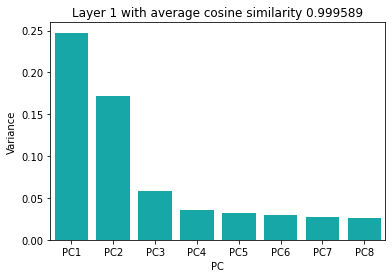

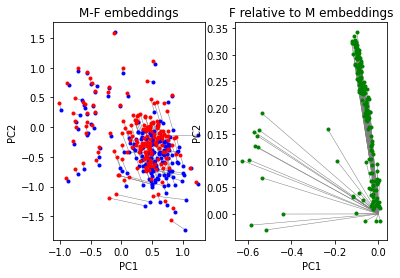

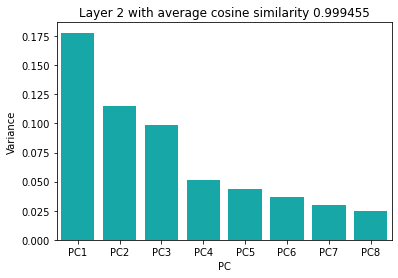

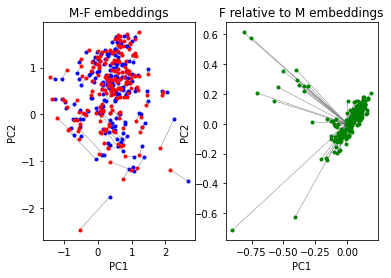

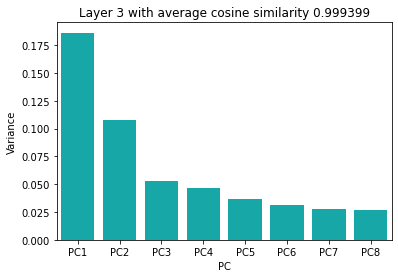

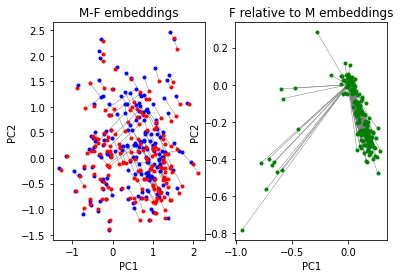

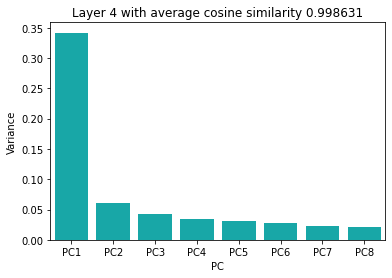

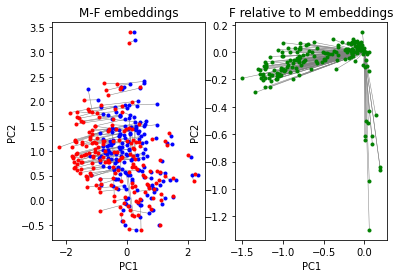

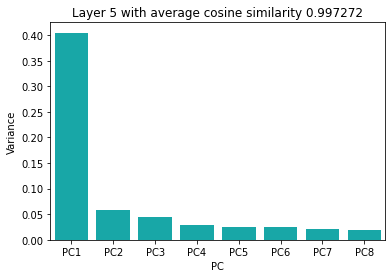

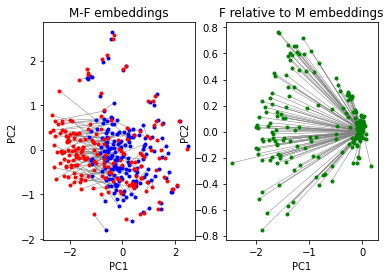

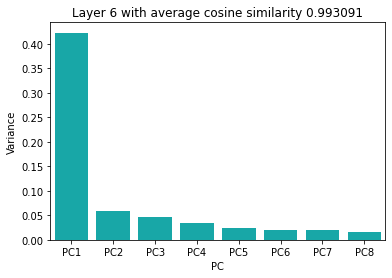

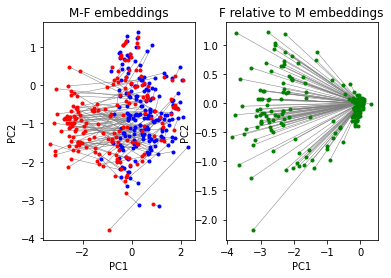

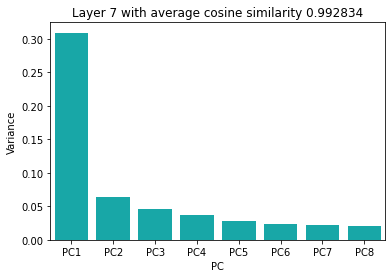

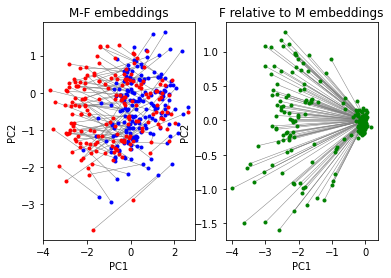

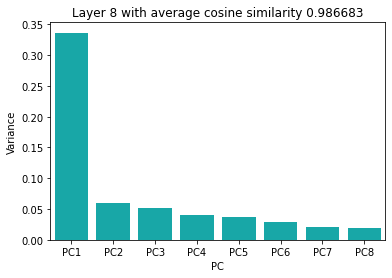

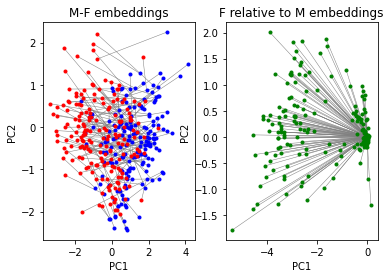

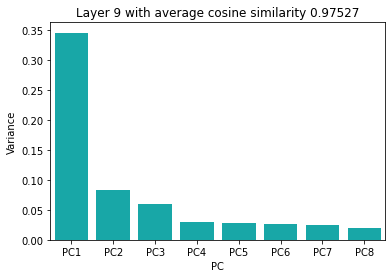

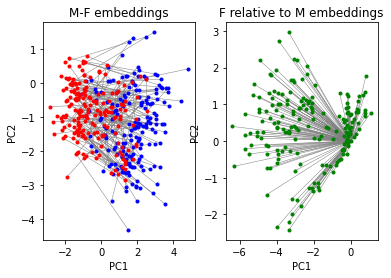

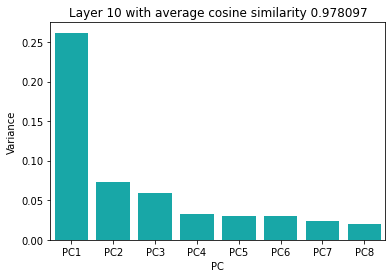

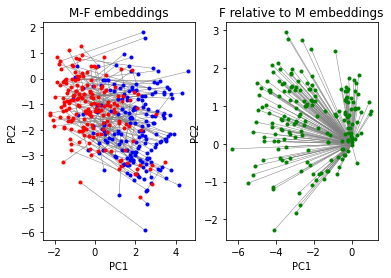

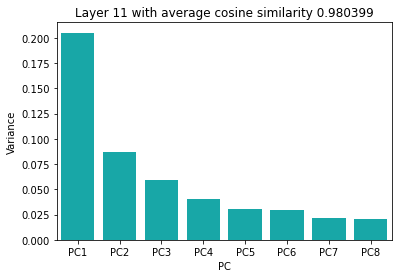

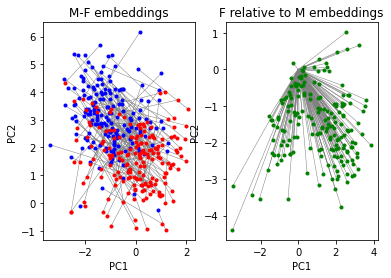

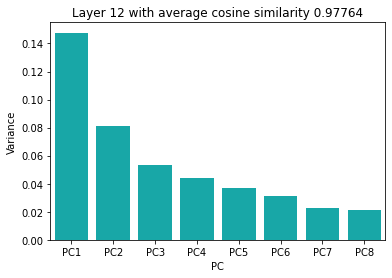

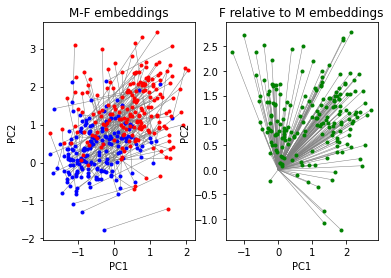

In [31]:
def run_pca(embedding_df,layer = -1,number_to_plot = None, which_to_plot='both',plot_dim = 2,annotate = 0):
  
  if type(layer) == 'list': # if a list with integers denoting which layers to plot, is given
    pass
  elif layer == 'all':
    layers = range(1,13) ######## Assuming all methods use 1+12 layers, but first layer is a static embedding and will therefore have the same male and female vectors for the professions
  else: # if a single integer for layer is given 
    layers = [layer]
  num_sentences = len(embedding_df)
  dimensions = np.array(embedding_df['male'][0][0]).size # assuming all layers have the same dimension
    
  #word_index = embedding_df['token_index']+shift
  # tot_var = np.zeros((12,dimensions))
  for layer in layers:
    #dimensions = np.array(embedding_df['male'][0][layer]).size
    professions = list(embedding_df['profession'])
    
    data = np.zeros((len(embedding_df),dimensions))
    embeddings = np.zeros((2,len(embedding_df),dimensions))
    for i in range(num_sentences):
      data[i,:] = np.array(embedding_df['male'][i][layer])-np.array(embedding_df['female'][i][layer])
      embeddings[0,i] = embedding_df['male'][i][layer]
      embeddings[1,i] = embedding_df['female'][i][layer]
      
    pca = PCA(n_components=8)
    pc = pca.fit_transform(data)
    #pc_df = pd.DataFrame(data = pc , 
         # columns = ['PC1', 'PC2','PC3','PC4'])
    num_pairs = len(embeddings[0])
    # for i,component in enumerate(pca.components_):
    #     tot_var[layer-1,i]= np.abs(np.mean((embeddings[1]-embeddings[0]) @ component, axis=0))
          
    
    if which_to_plot != 'vectors':
      cosim = np.mean(np.sum(embeddings[0]*embeddings[1],axis=1)/np.sqrt((np.sum(embeddings[0]**2,axis=1))*np.sum(embeddings[1]**2,axis=1)))
      df = pd.DataFrame({'Variance':pca.explained_variance_ratio_,'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']})
      plt.figure()
      sns.barplot(x='PC',y='Variance', 
              data=df, color='c',).set_title(f'Layer {layer} with average cosine similarity {np.round(cosim,6)}' )
      plt.show()
      
      
      
    if which_to_plot != 'hist':
      
      projections = np.zeros((2, num_pairs,plot_dim))
      for i,component in enumerate(pca.components_[:plot_dim]):
        projections[:,:,i] = embeddings @ component
      
          
      if number_to_plot is None:
        number_to_plot = num_pairs  
      
      if plot_dim == 2:
        plt.figure()

        #plt.legend('Male', 'Female')  
        plt.subplot(1,2,1)
        for i in range(0, number_to_plot):
            plt.plot([projections[0][i][0],projections[1][i][0]], [projections[0][i][1],projections[1][i][1]], color = 'grey', linewidth=0.5,)
            if annotate==1: 
              plt.annotate(professions[i][1:-1],projections[0][i]) #print names
            else:
              pass

        plt.plot(projections[0,:number_to_plot,0],projections[0,:number_to_plot,1], '.b')
        plt.plot(projections[1,:number_to_plot,0],projections[1,:number_to_plot,1], '.r')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('M-F embeddings')
        plt.subplot(1,2,2)
        for i in range(0, number_to_plot):
            plt.plot([0,projections[1][i][0]-projections[0][i][0]], [0,projections[1][i][1]-projections[0][i][1]], color = 'grey', linewidth=0.5,)
            if annotate: plt.annotate(professions[i][1:-1],projections[0][i]) #print names
        plt.plot(projections[1,:number_to_plot,0]-projections[0,:number_to_plot,0],projections[1,:number_to_plot,1]-projections[0,:number_to_plot,1], '.g')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('F relative to M embeddings')
        
      else:
        fig = plt.figure()
        ax = fig.add_subplot(121, projection='3d')
        
        for i in range(0, number_to_plot):
            plt.plot([projections[0][i][0],projections[1][i][0]], [projections[0][i][1],projections[1][i][1]],[projections[0][i][2],projections[1][i][2]], color = 'grey', linewidth=0.5,)
            if annotate: plt.annotate(professions[i][1:-1],projections[0][i]) #print names
        plt.plot(projections[0,:number_to_plot,0],projections[0,:number_to_plot,1],projections[0,:number_to_plot,2], '.b')
        plt.plot(projections[1,:number_to_plot,0],projections[1,:number_to_plot,1],projections[1,:number_to_plot,2], '.r')
        
        
        ax = fig.add_subplot(122, projection='3d')
        for i in range(0, number_to_plot):
           plt.plot([0,projections[1][i][0]-projections[0][i][0]], [0,projections[1][i][1]-projections[0][i][1]], color = 'grey', linewidth=0.5,)
           if annotate: plt.annotate(professions[i][1:-1],projections[0][i]) #print names
        plt.plot(projections[1,:number_to_plot,0]-projections[0,:number_to_plot,0],projections[1,:number_to_plot,1]-projections[0,:number_to_plot,1],projections[1,:number_to_plot,2]-projections[0,:number_to_plot,2], '.g')
      
      
  plt.show()
  ## plots abs(mean(difference between male and female vector projections onto PCA's))
  # plt.figure()
  # for i in range(tot_var.shape[1]):
  #   plt.plot(range(len(layers)), tot_var[:,i])
  # plt.title('Mean displacement between M and F embeddings across the layers across ')
  # plt.show()



run_pca(embedding_df, layer = 'all',plot_dim = 2)
